In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import set_random_seed

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  
pd.options.display.float_format = '{:.3f}'.format

In [46]:
df = pd.read_csv(r'C:\Users\User\Desktop\팀플3_딥러닝/data2.csv')
df.head()

,날짜,연월일,년,월,시간,시간_sin,시간_cos,호선,역번호,역명,...,상대습도,일사량,체감온도,혼잡도,승차총승객수,하차총승객수,미세먼지,미세먼지_level,요일,휴일여부
0,2021-01-01 00:00:00,2021-01-01,2021,1,0,0.000,1.000,1,150,서울역,...,66.400,0.000,-12.600,0.000,15284.000,16731.000,25.000,좋음,4,1
1,2021-01-01 00:00:00,2021-01-01,2021,1,0,0.000,1.000,1,1903,도봉산,...,66.400,0.000,-8.900,0.000,6483.000,6500.000,25.000,좋음,4,1
2,2021-01-01 00:00:00,2021-01-01,2021,1,0,0.000,1.000,2,236,영등포구청,...,64.600,0.000,-9.400,0.000,4319.000,4218.000,25.000,좋음,4,1
3,2021-01-01 00:00:00,2021-01-01,2021,1,0,0.000,1.000,6,2621,마포구청,...,62.800,0.000,-10.300,0.000,3604.000,3230.000,25.000,좋음,4,1
4,2021-01-01 00:00:00,2021-01-01,2021,1,0,0.000,1.000,7,2731,청담,...,52.600,0.000,-7.000,0.000,3080.000,3164.000,25.000,좋음,4,1


In [47]:
df = df.sort_values(by='날짜').set_index('날짜')

df['연월일'] = pd.to_datetime(df['연월일'])
int_col = '년 월 시간 요일 휴일여부'.split()
cat_col = '역명 상하구분 미세먼지_level 호선 년 월 요일 휴일여부 시간'.split()
df[int_col] = df[int_col].astype('int32')
df[cat_col] = df[cat_col].astype('category')

int_col = df.select_dtypes(np.number).columns
cat_col = list(set(df.columns)-set(df.select_dtypes(np.number).columns))

df_corr = df.copy()
혼잡도_corr = ['월', '시간', '시간_sin', '시간_cos', '호선', '역번호', '역명', '상하구분',
       '기온', '풍향', '풍속', '일강수량', '시간강수량', '상대습도', '일사량', '체감온도',
       '혼잡도', '승차총승객수', '하차총승객수', '미세먼지', '미세먼지_level', '요일', '휴일여부']
en_cols = list(set(혼잡도_corr)-set(df_corr[혼잡도_corr].select_dtypes(np.number).columns))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in en_cols:
    df_corr[col] = le.fit_transform(df_corr[col])

# 평균 혼잡도 / 승하차 승객 수

C:\Users\User\AppData\Local\Temp\ipykernel_9172\2149441351.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = df.groupby('호선')[['혼잡도', '하차총승객수', '승차총승객수']].mean().reset_index()


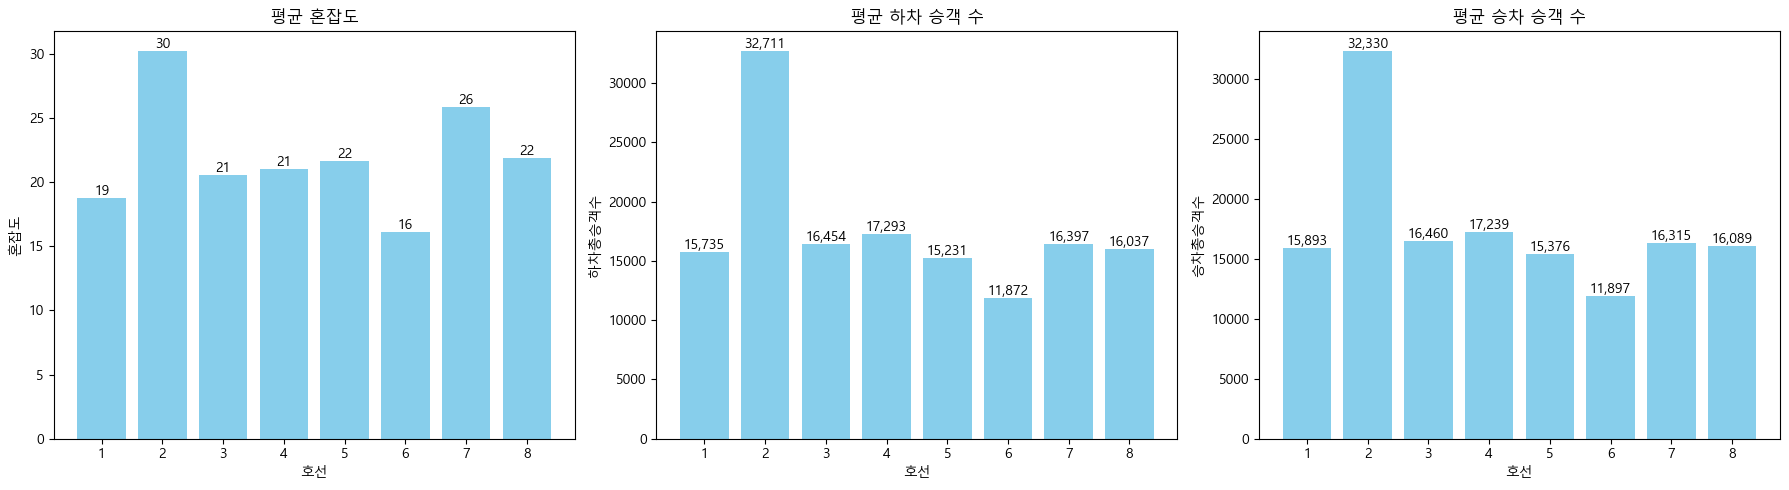

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# 예시: df에는 '호선', '혼잡도', '하차총승객수', '승차총승객수' 컬럼이 포함되어야 합니다.
# df = pd.read_csv(...)  # 실제 데이터 불러오기

# 평균값 계산
mean_df = df.groupby('호선')[['혼잡도', '하차총승객수', '승차총승객수']].mean().reset_index()

# 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['혼잡도', '하차총승객수', '승차총승객수']
titles = ['평균 혼잡도', '평균 하차 승객 수', '평균 승차 승객 수']

for ax, metric, title in zip(axes, metrics, titles):
    bars = ax.bar(mean_df['호선'], mean_df[metric], color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('호선')
    ax.set_ylabel(metric)
    
    # 막대 위에 숫자 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 혼잡도가 100이상인 데이터

In [10]:
#혼잡도가 100이상인 데이터 시간대 확인 -> 출/퇴근 시간 제외하고 기기
df_100=df[df['혼잡도']>100]
혼잡도시간대=df_100['시간'].value_counts().index
혼잡도시간대=혼잡도시간대[6:]

# 혼잡도가 100이상이면서 출/퇴근 시간이 아닌 데이터

In [12]:
df_100=df_100[df_100['시간'].isin(혼잡도시간대)]

#평일 혼잡한 시간대 확인
df_100[df_100['휴일여부']==0 ]['시간'].value_counts()
df_100_1=df_100[df_100['휴일여부']==0 ]

In [18]:
df_100_1['역명'].value_counts().sort_values(ascending=False).head(10)

역명
어린이대공원    312
구일        209
중곡        172
서초        141
방배        134
군자        107
교대         87
용마산        52
사당         50
혜화         40
Name: count, dtype: int64

In [20]:
df_100_1[df_100_1['역명']=='구일']['시간'].value_counts() #고척돔 #대학교

시간
22    175
21     15
16      8
15      4
6       4
23      2
12      1
20      0
19      0
18      0
17      0
0       0
14      0
1       0
11      0
10      0
9       0
8       0
7       0
5       0
13      0
Name: count, dtype: int64

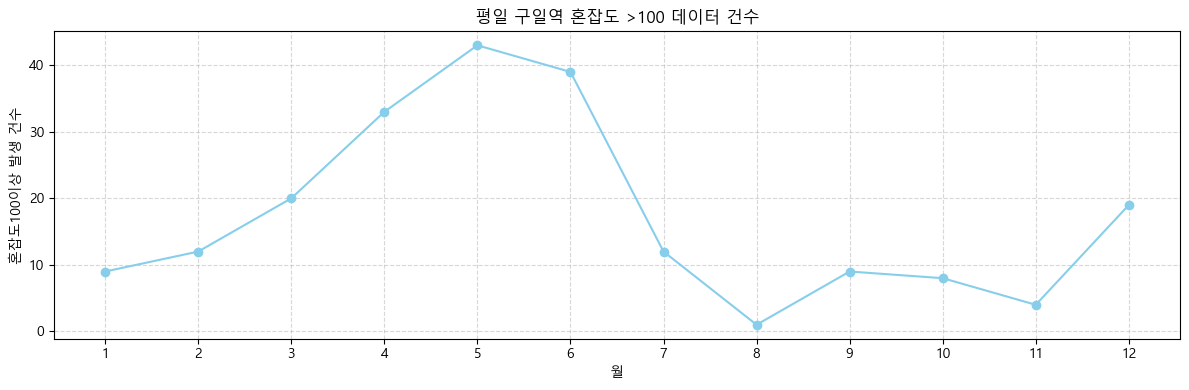

In [22]:
import matplotlib.pyplot as plt

# 1. 구일역의 날짜 데이터 추출
guui_dates = df_100_1[df_100_1['역명'] == '구일']['월']

# 2. 날짜별 건수 세기
date_counts = guui_dates.value_counts().sort_index()  # 날짜순 정렬

# 3. 시각화
plt.figure(figsize=(12, 4))
plt.plot(date_counts.index.astype(str), date_counts.values, color='skyblue',marker='o')
plt.title('평일 구일역 혼잡도 >100 데이터 건수')
plt.xlabel('월')
plt.ylabel('혼잡도100이상 발생 건수')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 2024년 데이터 <호선별 총 승하차 인원>

In [33]:
import pandas as pd
import numpy as np
df=pd.read_csv('승객유형data.csv')
df['휴일여부']=df['휴일여부'].astype('category')
df=df.rename(columns={'총승차인원':'총승하차인원'})

In [34]:
def format_korean_number(num):
    if num >= 100000000:
        return f'{num // 100000000}억'
    elif num >= 10000000:
        return f'{num // 1000000}백만'
    elif num >= 10000:
        return f'{num // 10000}만'
    else:
        return str(num)

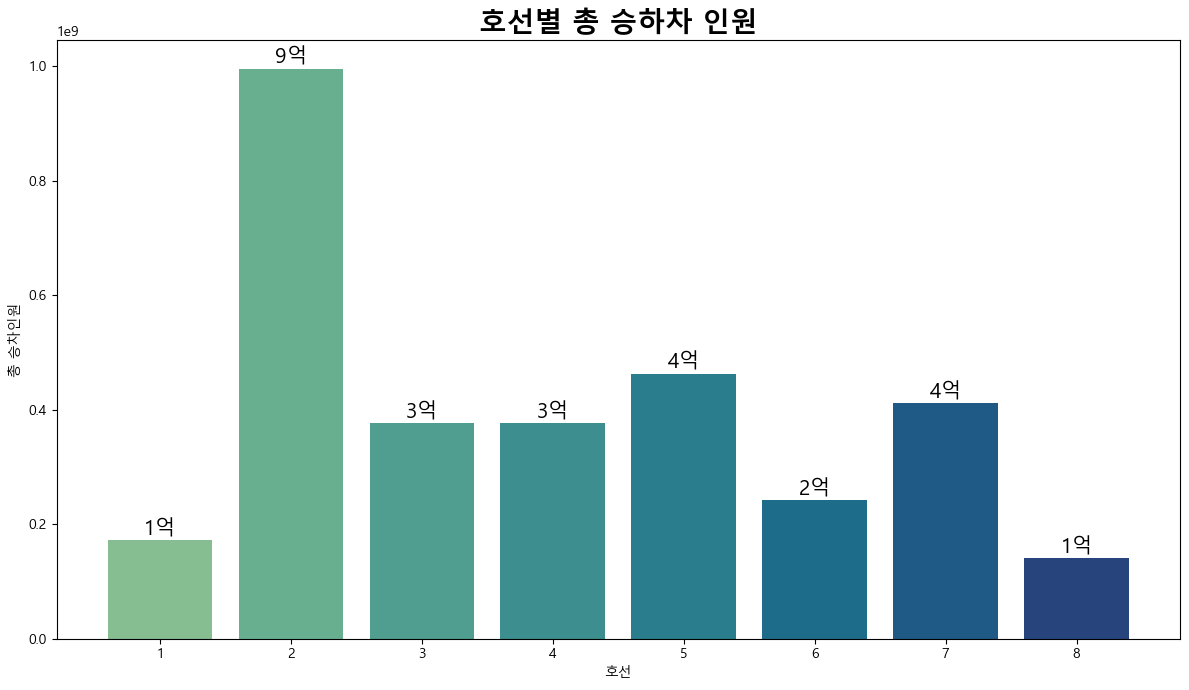

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 숫자를 억/백만/만 단위로 한글로 표현해주는 함수
def format_korean_number(num):
    if num >= 100000000:
        return f'{num // 100000000}억'
    elif num >= 10000000:
        return f'{num // 1000000}백만'
    elif num >= 10000:
        return f'{num // 10000}만'
    else:
        return str(num)

# 호선별 총 승하차 인원 계산
호선별_총승하차 = df.groupby('호선')['총승하차인원'].sum().reset_index()

# 파란색 계열 예쁜 팔레트
colors = sns.color_palette("crest", n_colors=len(호선별_총승하차))

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(호선별_총승하차['호선'], 호선별_총승하차['총승하차인원'], color=colors)

# 텍스트 삽입 (막대 위에)
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 50000,
        format_korean_number(int(height)),
        ha='center', va='bottom',
        fontsize=15, color='black'
    )

# 스타일 설정
ax.grid(False)
plt.title('호선별 총 승하차 인원', fontsize=20, fontweight='bold')  # 볼드체 제목
plt.xlabel('호선')
plt.ylabel('총 승차인원')
plt.tight_layout()
plt.show()
